IOANNIS MPOUZAS
AM:5025

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
# Define paths to our data directories
train_data_dir = 'your path'
test_data_dir = 'your path'


In [ ]:
# Create an ImageDataGenerator instance
train_datagen = ImageDataGenerator()

# Flow training images in batches using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    class_mode='binary',
    classes=['unpleasant','pleasant']
)

Found 6376 images belonging to 2 classes.


Some informations about our dataset

In [ ]:
# Print some information about the training generator
print("Class Indices:", train_generator.class_indices)
print("Classes:", train_generator.classes)
print("Number of Images:", train_generator.samples)
print("Batch Size:", train_generator.batch_size)
print("Image Shape:", train_generator.image_shape)

Class Indices: {'unpleasant': 0, 'pleasant': 1}
Classes: [0 0 0 ... 1 1 1]
Number of Images: 6376
Batch Size: 32
Image Shape: (256, 256, 3)


We print some photos of our dataset

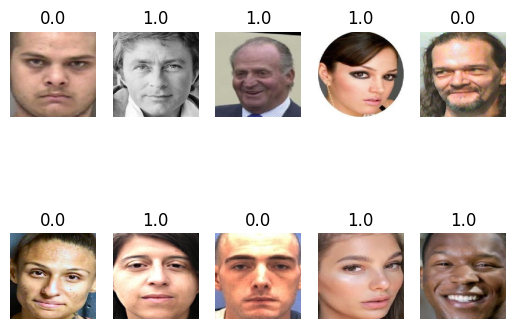

In [ ]:
import matplotlib.pyplot as plt

# Get the first batch of images and labels
batch_x, batch_y = train_generator.__next__()

# Display the first 10 images
for i in range(10):
  plt.subplot(2, 5, i + 1)  # Create a grid of subplots
  plt.imshow(batch_x[i] / 255.0) # normalize manually
  plt.title(batch_y[i])  # Set the title as the class label
  plt.axis('off')  # Turn off axis ticks and labels

plt.show()  # Show the plot

We preproccess our training data in order to have more robust models

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, # Rescale pixel values to the range [0, 1]
                                   rotation_range=20, # Randomly rotate images by up to 20 degrees
                                   width_shift_range=0.2, # Randomly shift images horizontally by up to 20% of the width
                                   height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
                                   shear_range=0.2, # Apply random shear transformations
                                   zoom_range=0.2, # Randomly zoom in or out on images by up to 20%
                                   horizontal_flip=True, # Randomly flip images horizontally
                                   fill_mode='nearest',  # Fill in any missing pixels after transformations using the nearest pixel value
                                   validation_split=0.2 # Split data into training and validation sets (20% for validation)
                                  )

test_datagen = ImageDataGenerator(rescale=1./255) # Only rescale pixel values for test data

In [ ]:
# Create training and validation image_dataset_from_directory
train_generator = train_datagen.flow_from_directory(
    'your path',
    subset="training",
    seed=123,
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    target_size=(128, 128),
    shuffle=True,
    batch_size=64
)




Found 5102 images belonging to 2 classes.


In [ ]:
# Create the validation set
val_ds = train_datagen.flow_from_directory(
    'your path',
    subset="validation",
    seed=123,
    target_size=(128, 128),
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    batch_size=64,
    shuffle=False
)

Found 1274 images belonging to 2 classes.


In [ ]:
def train_and_evaluate(model, train_generator, val_ds, epochs=10):
  """
  Trains and evaluates a Keras model.

  Args:
      model: The Keras model to train.
      train_generator: The training data generator.
      val_ds: The validation dataset.
      epochs: The number of training epochs.

  Returns:
      The training history.
  """
  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model
  history = model.fit(train_generator, validation_data=val_ds, epochs=epochs)

  # Evaluation
  y_probs = model.predict(val_ds)
  y_pred = (y_probs > 0.5).astype(int).flatten()
  y_true = val_ds.classes

  # Print classification report and metrics
  print("\nClassification Report:")
  print(classification_report(y_true, y_pred, target_names=val_ds.class_indices.keys()))
  print(f" Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
  print(f" Precision: {precision_score(y_true, y_pred):.4f}")
  print(f" Recall:    {recall_score(y_true, y_pred):.4f}")
  print(f" F1 Score:  {f1_score(y_true, y_pred):.4f}")

  return history


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
# A simple cnn model

model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel, ReLU activation, and input shape
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))

# Flatten the output from the convolutional layer
model.add(Flatten())

# Add a dense layer with 1 neuron (for binary classification) and sigmoid activation
model.add(Dense(1, activation='sigmoid'))


model.summary()

history1 = train_and_evaluate(model, train_generator, val_ds, epochs=10)


In [ ]:
# Second model with maxPooling layer

model2 = Sequential([

    # First convolutional layer with 32 filters of size 3x3, using ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),

    # MaxPooling layer to downsample the feature maps
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer to convert 2D feature maps into 1D feature vector
    Flatten(),

    # Output layer with 1 unit (binary classification) and sigmoid activation
    Dense(1, activation='sigmoid')
])

model2.summary()

history2 = train_and_evaluate(model2, train_generator, val_ds, epochs=10)


In [ ]:
# 3d model

model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer with more filters (64 instead of 32)
    # This allows the model to learn more complex features
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),

    # Dropout layer to reduce overfitting by randomly disabling 50% of neurons during training
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model3.summary()

history3 = train_and_evaluate(model3, train_generator, val_ds, epochs=10)


In [ ]:
# 4th model

model4 = Sequential([

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(), # Helps stabilize and speed up training
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'), # Extra dense layer for richer learning
    Dropout(0.3), # Regularization to prevent overfitting
    Dense(1, activation='sigmoid')
])

model4.summary()

history4 = train_and_evaluate(model4, train_generator, val_ds, epochs=10)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,305 (14.14 MB)

 Trainable params: 3,706,113 (14.14 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 495ms/step - accuracy: 0.6620 - loss: 1.9306 - val_accuracy: 0.5039 - val_loss: 2.9605
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 459ms/step - accuracy: 0.7244 - loss: 0.5530 - val_accuracy: 0.5526 - val_loss: 3.5078
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step - accuracy: 0.7576 - loss: 0.5447 - val_accuracy: 0.6570 - val_loss: 2.8930
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - accuracy: 0.7741 - loss: 0.4724 - val_accuracy: 0.6476 - val_loss: 2.8266
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.7757 - loss: 0.4784 - val_accuracy: 0.6782 - val_loss: 2.6072
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 459ms/step - accuracy: 0.8053 - loss: 0.4193 - val_accuracy: 0.7198 - val_loss: 1.5651
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - accuracy: 0.8035 - loss: 0.4117 - val_accuracy: 0.7206 - val_loss: 0.8057
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 459ms/step - accuracy: 0.8200 - loss: 0.3855 - val_accu

In [ ]:
# 5th model

model5 = Sequential([

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'), # Increased capacity with 128 units
    Dropout(0.5), # Strong regularization
    Dense(1, activation='sigmoid')
])

model5.summary()

history5 = train_and_evaluate(model5, train_generator, val_ds, epochs=10)



Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 46s 509ms/step - accuracy: 0.6736 - loss: 1.1935 - val_accuracy: 0.4843 - val_loss: 2.7748
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - accuracy: 0.7682 - loss: 0.4865 - val_accuracy: 0.6389 - val_loss: 1.0855
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 464ms/step - accuracy: 0.7791 - loss: 0.4730 - val_accuracy: 0.5369 - val_loss: 0.8254
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 470ms/step - accuracy: 0.8068 - loss: 0.4267 - val_accuracy: 0.4945 - val_loss: 1.2062
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.8108 - loss: 0.4156 - val_accuracy: 0.6876 - val_loss: 0.6479
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.8215 - loss: 0.3917 - val_accuracy: 0.6797 - val_loss: 0.7672
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 472ms/step - accuracy: 0.8520 - loss: 0.3542 - val_accuracy: 0.6240 - val_loss: 1.1198
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.8463 - loss: 0.3479 - val_accu

In [ ]:
# 6th model

model6 = Sequential([

    # Define a deep CNN with more convolutional layers and 'same' padding for better feature extraction
    # First convolutional block (32 filters)
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),# Max pooling to reduce spatial dimensions

    # Second convolutional block (64 filters)
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block (128 filters)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dropout(0.5),# Regularization
    Dense(128, activation='relu'),# Dense layer with 128 units
    Dropout(0.5),# Another dropout for stronger regularization
    Dense(1, activation='sigmoid')
])

model6.summary()

history6 = train_and_evaluate(model6, train_generator, val_ds, epochs=10)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,333,985 (16.53 MB)

 Trainable params: 4,333,985 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 573ms/step - accuracy: 0.5656 - loss: 0.6603 - val_accuracy: 0.7229 - val_loss: 0.5537
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 474ms/step - accuracy: 0.7167 - loss: 0.5567 - val_accuracy: 0.7033 - val_loss: 0.5666
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 472ms/step - accuracy: 0.7408 - loss: 0.5260 - val_accuracy: 0.7300 - val_loss: 0.5054
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 476ms/step - accuracy: 0.7403 - loss: 0.5161 - val_accuracy: 0.7441 - val_loss: 0.5007
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 474ms/step - accuracy: 0.7758 - loss: 0.4809 - val_accuracy: 0.7339 - val_loss: 0.4987
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.7563 - loss: 0.4824 - val_accuracy: 0.7355 - val_loss: 0.5151
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.7924 - loss: 0.4498 - val_accuracy: 0.7245 - val_loss: 0.5227
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 470ms/step - accuracy: 0.8012 - loss: 0.4250 - val_accu

In [ ]:
# 7th model

model7 = Sequential([

    # Define a deep CNN with BatchNormalization and higher complexity
    # First convolutional block (64 filters)
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(), # Normalize activations for faster convergence
    MaxPooling2D((2, 2)),# Max pooling to reduce spatial dimensions

    # Second convolutional block (128 filters)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third convolutional block (256 filters)
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dropout(0.5),# Regularization to reduce overfitting
    Dense(512, activation='relu'), # Dense layer with 512 units
    BatchNormalization(),# Normalize activations
    Dropout(0.5),# Another dropout layer
    Dense(128, activation='relu'), # Dense layer with 128 units
    BatchNormalization(),# Normalize activations again
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.001)


model7.summary()


history7 = train_and_evaluate(model7, train_generator, val_ds, epochs=10)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,770,497 (132.64 MB)

 Trainable params: 34,768,321 (132.63 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 97s 865ms/step - accuracy: 0.6918 - loss: 0.6286 - val_accuracy: 0.4812 - val_loss: 1.3017
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 472ms/step - accuracy: 0.7863 - loss: 0.4541 - val_accuracy: 0.4678 - val_loss: 1.7971
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.8065 - loss: 0.4069 - val_accuracy: 0.5220 - val_loss: 0.7497
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 470ms/step - accuracy: 0.8171 - loss: 0.3961 - val_accuracy: 0.5157 - val_loss: 1.1571
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 476ms/step - accuracy: 0.8298 - loss: 0.3668 - val_accuracy: 0.6907 - val_loss: 0.7291
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 479ms/step - accuracy: 0.8490 - loss: 0.3368 - val_accuracy: 0.6845 - val_loss: 0.8077
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - accuracy: 0.8508 - loss: 0.3192 - val_accuracy: 0.7002 - val_loss: 0.7982
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 474ms/step - accuracy: 0.8651 - loss: 0.3048 - val_accu

In [ ]:
# 8th model

model8 = Sequential([

    # Define a CNN with BatchNormalization, Dropout, and moderate complexity
    # First convolutional block (32 filters)
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block (64 filters)
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional block (64 filters)
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Define optimizer with a learning rate of 0.0005
optimizer = Adam(learning_rate=0.0005)


model8.summary()


history8 = train_and_evaluate(model8, train_generator, val_ds, epochs=10)



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,154,881 (8.22 MB)

 Trainable params: 2,154,305 (8.22 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - accuracy: 0.7367 - loss: 0.6177 - val_accuracy: 0.4678 - val_loss: 2.3273
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - accuracy: 0.8067 - loss: 0.4218 - val_accuracy: 0.4678 - val_loss: 2.1239
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 462ms/step - accuracy: 0.8153 - loss: 0.3996 - val_accuracy: 0.5526 - val_loss: 1.3417
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - accuracy: 0.8479 - loss: 0.3514 - val_accuracy: 0.4859 - val_loss: 2.4748
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step - accuracy: 0.8555 - loss: 0.3465 - val_accuracy: 0.7009 - val_loss: 0.6563
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - accuracy: 0.8613 - loss: 0.3295 - val_accuracy: 0.7033 - val_loss: 0.7815
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 462ms/step - accuracy: 0.8688 - loss: 0.3004 - val_accuracy: 0.7276 - val_loss: 0.6789
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - accuracy: 0.8767 - loss: 0.2903 - val_accu

Plot the accuracy of all the models

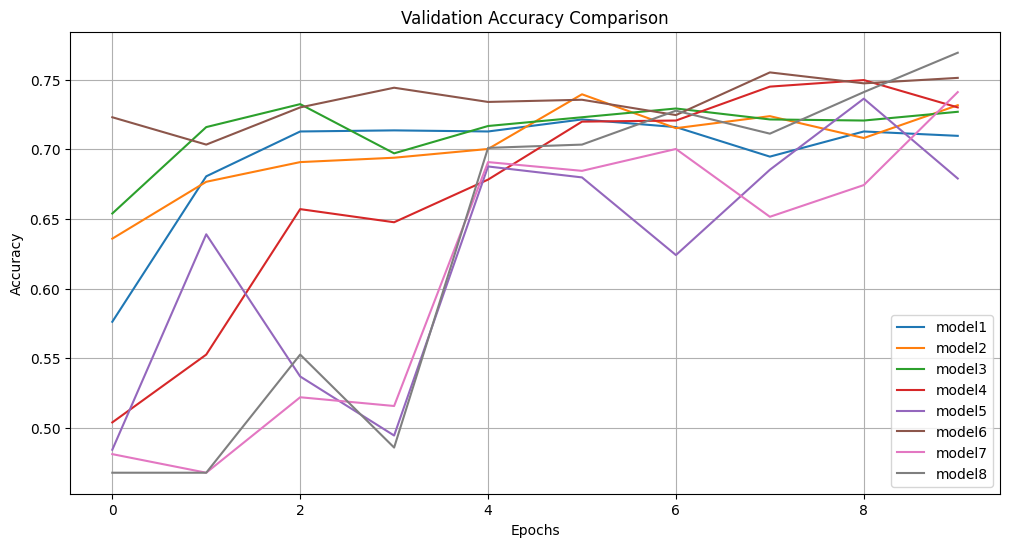

In [ ]:
import matplotlib.pyplot as plt

histories = [history1, history2, history3, history4, history5, history6, history7, history8]
labels = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8']

# Plot Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f'{labels[i]}')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Plot the loss of all the models

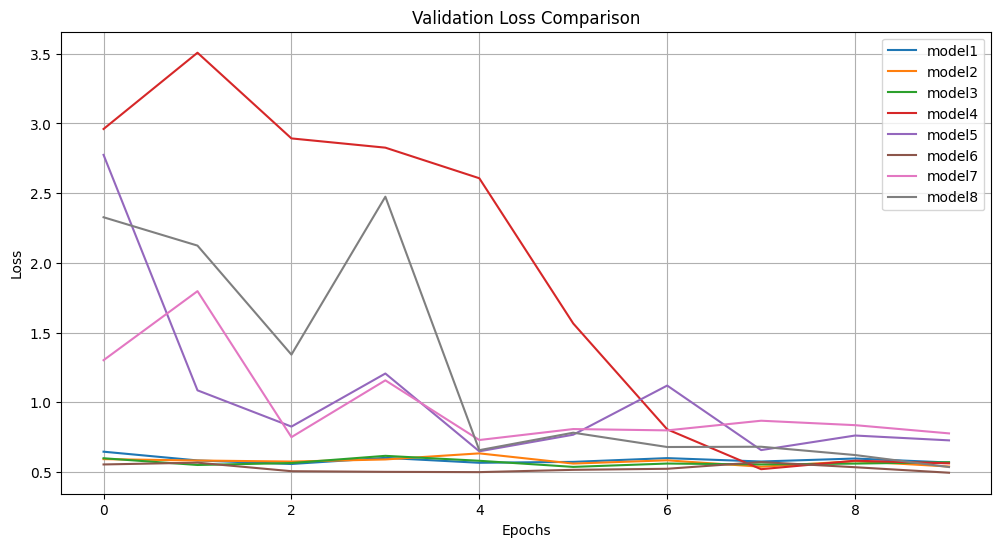

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f'{labels[i]}')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# Read the csv test data file

csv_data = pd.read_csv('your path')

In [ ]:
target_height, target_width = 128, 128
batch_size = 64

In [ ]:
test_filepaths = [os.path.join(test_data_dir, filename) for filename in csv_data['Filename']]
# Create a list of file paths for all images in the test directory.
# os.path.join is used to correctly join directory and filename.
# We iterate through the 'Filename' column of the csv_data DataFrame to get all filenames.


def load_and_preprocess_image(path):
  """Loads an image from a file path, preprocesses it, and returns the processed image."""
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [target_height, target_width])
  image = image / 255.0
  return image

In [ ]:
# Creates a tf.data.Dataset from the list of file paths. Each element of the dataset is a file path.
test_dataset = tf.data.Dataset.from_tensor_slices(test_filepaths)


# Applies the 'load_and_preprocess_image' function to each element (file path) in the dataset.
# num_parallel_calls=tf.data.AUTOTUNE allows TensorFlow to automatically determine the optimal number of threads for preprocessing.
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


# Groups the elements of the dataset into batches of size 'batch_size'. This is important for efficient training and prediction.
test_dataset = test_dataset.batch(batch_size)


# Prefetches data to improve performance. It prepares the next batch of data in the background while the current batch is being processed.
# tf.data.AUTOTUNE allows TensorFlow to automatically determine the optimal prefetch buffer size.
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Makes predictions on the test dataset using your trained model.
predictions = model.predict(test_dataset)


# Converts the predictions (probabilities) into binary labels (0 or 1).
# Values above 0.5 are assigned label 1, and values below 0.5 are assigned label 0.
# flatten() is used to ensure the labels are in a 1-dimensional array.
predicted_labels = (predictions > 0.5).astype(int).flatten()


# Creates a pandas DataFrame to store the IDs and predicted labels. This DataFrame is typically used for creating a submission file.
submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': predicted_labels
})

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


In [ ]:
# here we save our csv submission file
submission.to_csv('save your submission file somewhere', index=False, columns=['ID', 'LABEL'])

2nd PART
We will use a pretrained model in order to extract vector representations (features) from the images

In [ ]:
# Same as before but here the target size is (224,224)
train_generator = train_datagen.flow_from_directory(
    'your path',
    subset="training",
    seed=123,
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    target_size=(224, 224),
    shuffle=True,
    batch_size=64
)

Found 5102 images belonging to 2 classes.


In [ ]:
val_ds = train_datagen.flow_from_directory(
    'your path',
    subset="validation",
    seed=123,
    target_size=(224, 224),
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    batch_size=64,
    shuffle=False
)

Found 1274 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Load the pre-trained model without the classification layer
# (224,224) is the default size of the ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def extract_features(generator):
    """
    Extracts features from images using a pre-trained model.

    Args:
        generator: A Keras ImageDataGenerator for the dataset.

    Returns:
        features: A NumPy array of extracted features.
        labels: A NumPy array of corresponding labels.
    """
    features = base_model.predict(generator, verbose=1)
    features = features.reshape(features.shape[0], -1)
    labels = generator.classes
    return features, labels


In [ ]:
# Here we do the same for the test fotos, we preprocess and then
# extract features for these fotos using the pretrained model

import numpy as np
import pandas as pd
import os

csv_data = pd.read_csv('your data')

target_height, target_width = 224, 224
batch_size = 64


test_filepaths = [os.path.join(test_data_dir, filename) for filename in csv_data['Filename']]


def load_and_preprocess_image(path):

    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width])
    image = image / 255.0
    return image


test_dataset = tf.data.Dataset.from_tensor_slices(test_filepaths)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

def extract_features_from_test(dataset):
    features = []
    for batch_x in dataset:
        batch_features = base_model.predict(batch_x)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.extend(batch_features)
    return np.array(features)



In [ ]:
X_train, y_train = extract_features(train_generator)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2199s 28s/step


In [ ]:
X_val, y_val = extract_features(val_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 430s 23s/step


In [ ]:
X_test = extract_features_from_test(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
from sklearn.preprocessing import StandardScaler

# here we scale the features, important step
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# here we can see the shape of our datasets

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(5102, 100352)
(1274, 100352)
(500, 100352)


In [ ]:
# Because the number of features extracted is so big(100352)
# we use SelectKBest to select the top k features based on a scoring function.
# f_classif is the scoring function that uses ANOVA F-value to rank features
# for classification problems.
# Here k is 100

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=100)
X_train_kbest = selector.fit_transform(X_train_scaled, y_train)
X_val_kbest = selector.transform(X_val_scaled)
X_test_kbest = selector.transform(X_test_scaled)


In [ ]:
print(X_train_kbest.shape)
print(X_val_kbest.shape)
print(X_test_kbest.shape)

(5102, 100)
(1274, 100)
(500, 100)


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

best_f1 = 0 # Initialize variable to store the best F1 score
best_model = None # Initialize variable to store the best model
best_params = {} # Initialize dictionary to store the best hyperparameters

y_true = val_ds.classes # Get the true labels for the validation set

for k in [1, 3, 5, 7, 9, 10, 15, 25]:# Iterate through different values for k (number of neighbors)
    for metric in ['euclidean', 'manhattan', 'chebyshev', 'cosine']:# Iterate through different distance metrics
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)# Create a KNN classifier with the current hyperparameters
        knn.fit(X_train_kbest, y_train)# Train the KNN model on the training data

        y_pred = knn.predict(X_val_kbest)# Make predictions on the validation data

        print(f'\nMetric={metric}, K={k}')
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=val_ds.class_indices.keys()))

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        print(f"\n Accuracy:  {acc:.4f}")
        print(f" Precision: {prec:.4f}")
        print(f" Recall:    {rec:.4f}")
        print(f" F1 Score:  {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = knn
            best_params = {'k': k, 'metric': metric}

# Final best model info
print(f"\nBest Model — Metric: {best_params['metric']}, K: {best_params['k']}, F1 Score: {best_f1:.4f}")

# Use the best model to predict on validation or test data
final_predictions = best_model.predict(X_test_kbest)

submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': final_predictions
})

submission.to_csv('save knn', index=False, columns=['ID', 'LABEL'])


Metric=euclidean, K=1
Classification Report:
              precision    recall  f1-score   support

  unpleasant       0.48      0.50      0.49       596
    pleasant       0.55      0.53      0.54       678

    accuracy                           0.52      1274
   macro avg       0.52      0.52      0.52      1274
weighted avg       0.52      0.52      0.52      1274


 Accuracy:  0.5165
 Precision: 0.5154
 Recall:    0.5155
 F1 Score:  0.5153

Metric=manhattan, K=1
Classification Report:
              precision    recall  f1-score   support

  unpleasant       0.50      0.50      0.50       596
    pleasant       0.56      0.57      0.57       678

    accuracy                           0.54      1274
   macro avg       0.53      0.53      0.53      1274
weighted avg       0.54      0.54      0.54      1274


 Accuracy:  0.5361
 Precision: 0.5340
 Recall:    0.5340
 F1 Score:  0.5340

Metric=chebyshev, K=1
Classification Report:
              precision    recall  f1-score   support


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import AUC, Precision, Recall

In [ ]:
def build_mlp_model(hidden_layers, activation, optimizer_name, input_dim, learning_rate=0.01):
    """
    Builds and compiles a Multi-Layer Perceptron (MLP) model.

    Args:
        hidden_layers: A list of integers representing the number of units in each hidden layer.
        activation: The activation function to use for hidden layers.
        optimizer_name: The name of the optimizer to use ('Adam', 'SGD', or 'RMSprop').
        input_dim: The dimensionality of the input data.
        learning_rate: The learning rate for the optimizer (default: 0.01).

    Returns:
        A compiled Keras MLP model.
    """

    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layers[0], activation=activation, input_shape=(input_dim,)))
    # Add the first hidden layer with the specified activation and input shape
    # Add batch normalization for faster and more stable training
    model.add(BatchNormalization())

    # Hidden layers (if more than one)
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))# Add a dense layer with the specified activation
        model.add(BatchNormalization()) # Add batch normalization
        model.add(Dropout(0.2))# Add dropout for regularization to prevent overfitting

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    # Add the output layer with a sigmoid activation for binary classification

    # Optimizer selection
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)


    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(), Precision(), Recall()])
    return model

In [ ]:
# Here we initialize some mlp models, from shallow to deep networks

model_configs = [
    {'id': 1, 'layers': [512], 'activation': 'relu',    'optimizer': 'Adam'},
    {'id': 2, 'layers': [512, 256], 'activation': 'relu',    'optimizer': 'SGD'},
    {'id': 3, 'layers': [256, 128, 64], 'activation': 'sigmoid', 'optimizer': 'Adam'},
    {'id': 4, 'layers': [512, 256, 128, 64], 'activation': 'tanh',    'optimizer': 'SGD'},
    {'id': 5, 'layers': [256], 'activation': 'relu',    'optimizer': 'Adam'},
    {'id': 6, 'layers': [256, 128], 'activation': 'tanh',    'optimizer': 'Adam'},
    {'id': 7, 'layers': [128, 128, 64, 64], 'activation': 'sigmoid', 'optimizer': 'SGD'},
    {'id': 8, 'layers': [64], 'activation': 'tanh',    'optimizer': 'SGD'}
]

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

input_dim = X_train_kbest.shape[1] # Get the input dimension from the training data
model_f1_scores = {} # Dictionary to store F1 scores for each model
best_model = None # Variable to store the best model
best_f1 = 0 # Variable to store the best F1 score
best_model_config = None # Variable to store the configuration of the best model

# Loop through model configurations
for config in model_configs:
    print(f"\nTraining Model {config['id']}...")

    # Build and compile the MLP model
    model = build_mlp_model(
        hidden_layers=config['layers'],
        activation=config['activation'],
        optimizer_name=config['optimizer'],
        input_dim=input_dim
    )

    # Train the model
    model.fit(
        X_train_kbest, y_train,
        validation_data=(X_val_kbest, y_val),
        epochs=10,
        batch_size=64,
        verbose=0
    )

    # Make predictions on the validation set
    y_probs = model.predict(X_val_kbest)

    # Convert probabilities to binary predictions
    y_pred = (y_probs > 0.5).astype(int).flatten()

    f1 = f1_score(y_val, y_pred)
    model_f1_scores[config['id']] = f1

    print("Classification Report:")
    print(classification_report(y_val, y_pred))

    print(f" Accuracy:  {accuracy_score(y_val, y_pred):.4f}")
    print(f" Precision: {precision_score(y_val, y_pred):.4f}")
    print(f" Recall:    {recall_score(y_val, y_pred):.4f}")
    print(f" F1 Score:  {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_config = config

print(f"\n✅ Best Model: {best_model_config['id']} with F1 Score: {best_f1:.4f}")

# Make final predictions on the test set using the best model
final_predictions = (best_model.predict(X_test_kbest) > 0.5).astype(int).flatten()


submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': final_predictions
})

submission.to_csv('save mlp', index=False, columns=['ID', 'LABEL'])


Training Model 1...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.57      0.52       596
           1       0.54      0.44      0.48       678

    accuracy                           0.50      1274
   macro avg       0.50      0.50      0.50      1274
weighted avg       0.51      0.50      0.50      1274

 Accuracy:  0.4992
 Precision: 0.5362
 Recall:    0.4366
 F1 Score:  0.4813

Training Model 2...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.41      0.42       596
           1       0.50      0.52      0.51       678

    accuracy                           0.47      1274
   macro avg       0.46      0.46      0.46      1274
weighted avg       0.47      0.47      0.47      1274

 Accuracy:  0.4670
 Precision: 0.4993
 Recall:    0.5162
 F1 Score:  0.5076

Training Model 3...
40/40 ━

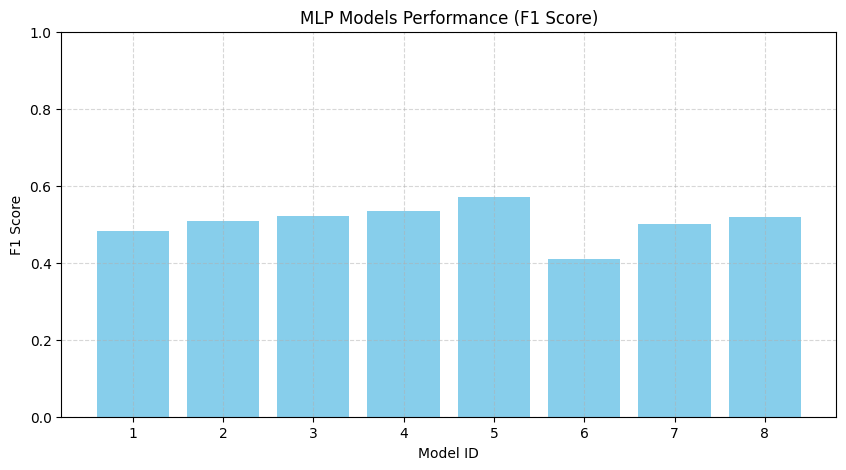

In [ ]:
# Here we print the mlp models performance based on the f1 score

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(model_f1_scores.keys(), model_f1_scores.values(), color='skyblue')
plt.xlabel("Model ID")
plt.ylabel("F1 Score")
plt.title("MLP Models Performance (F1 Score)")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the kernels and C values to try
kernels = ['linear', 'rbf'] # Define the kernels and C values to try
C_values = [0.1, 1, 10, 100] # List of regularization parameters (C) to evaluate

# Get true labels and target names for the validation set
y_true = val_ds.classes
target_names = list(val_ds.class_indices.keys())

# Initialize variables to store the best model and its performance
best_f1 = 0
best_model = None
best_params = {}
avg_type = 'binary'

# Iterate through kernels and C values
for kernel in kernels:
    for C in C_values:
        # Create and train the SVM model
        if kernel == 'linear':
            svm = LinearSVC(C=C, max_iter=10000) # Create a LinearSVC model if kernel is 'linear'
        else:
            svm = SVC(kernel=kernel, C=C) # Create an SVC model with the specified kernel and C

        svm.fit(X_train_kbest, y_train) # Train the SVM model on the training data
        y_pred = svm.predict(X_val_kbest) # Make predictions on the validation data

        # Calculate evaluation metrics
        f1 = f1_score(y_true, y_pred, average=avg_type)
        prec = precision_score(y_true, y_pred, average=avg_type)
        rec = recall_score(y_true, y_pred, average=avg_type)
        acc = accuracy_score(y_true, y_pred)

        print(f"\n===== Kernel={kernel}, C={C} =====")
        print(classification_report(y_true, y_pred, target_names=target_names))
        print(f" Accuracy:  {acc:.4f}")
        print(f" Precision: {prec:.4f}")
        print(f" Recall:    {rec:.4f}")
        print(f" F1 Score:  {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = svm
            best_params = {'kernel': kernel, 'C': C}

print(f"\n✅ Best SVM Model — Kernel: {best_params['kernel']}, C: {best_params['C']}, F1 Score: {best_f1:.4f}")

# Final prediction
final_predictions = best_model.predict(X_test_kbest)

submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': final_predictions
})

submission.to_csv('save svm', index=False, columns=['ID', 'LABEL'])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get true labels and target names for the validation set
y_true = val_ds.classes
target_names = list(val_ds.class_indices.keys())
avg_type = 'binary'

# Initialize variables to store the best model and its performance
best_f1 = 0
best_model = None
best_C = None

# Iterate through different C values
for C in [0.01, 0.1, 1, 10, 100]:# List of C values to evaluate
    # Create and train the Logistic Regression model
    lr = LogisticRegression(C=C, max_iter=1000)

    # Train the model on the training data
    lr.fit(X_train_kbest, y_train)

    # Make predictions on the validation data
    y_pred = lr.predict(X_val_kbest)

    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average=avg_type)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=avg_type)
    rec = recall_score(y_true, y_pred, average=avg_type)

    print(f"\n===== C={C} =====")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model = lr
        best_C = C

print(f"\n✅ Best Logistic Regression Model — C: {best_C}, F1 Score: {best_f1:.4f}")

# Final prediction
final_predictions = best_model.predict(X_test_kbest)


submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': final_predictions
})

submission.to_csv('save logiregre', index=False, columns=['ID', 'LABEL'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get true labels, target names, and determine if it's a binary classification problem
y_true = val_ds.classes
target_names = list(val_ds.class_indices.keys())
is_binary = len(np.unique(y_true)) == 2
avg_type = 'binary'


# Initialize variables to store the best model and its performance
best_model = None
best_f1 = 0
best_model_name = ''


# Random Forest
for n in [10, 50, 100]:# Iterate through different numbers of estimators for Random Forest
    rf = RandomForestClassifier(n_estimators=n, max_depth=10, n_jobs=-1)
    rf.fit(X_train_kbest, y_train)# Train the Random Forest model on the training data

    y_pred = rf.predict(X_val_kbest)# Make predictions on the validation data


    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average=avg_type)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=avg_type)
    rec = recall_score(y_true, y_pred, average=avg_type)

    print(f"\n🌲 RandomForest (n_estimators={n})")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")

    if f1 > best_f1:
        best_model = rf
        best_f1 = f1
        best_model_name = f"RandomForest (n={n})"

# AdaBoost
for n in [100, 200]:# Iterate through different numbers of estimators for AdaBoost
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n)
    # Create an AdaBoost classifier with specified parameters
    ada.fit(X_train_kbest, y_train)# Train the AdaBoost model on the training data

    y_pred = ada.predict(X_val_kbest)# Make predictions on the validation data


    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average=avg_type)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=avg_type)
    rec = recall_score(y_true, y_pred, average=avg_type)

    print(f"\n⚡ AdaBoost (n_estimators={n})")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")

    if f1 > best_f1:
        best_model = ada
        best_f1 = f1
        best_model_name = f"AdaBoost (n={n})"

print(f"\n✅ Best Ensemble Model: {best_model_name} with F1 Score: {best_f1:.4f}")

# Final prediction
final_predictions = best_model.predict(X_test_kbest)

submission = pd.DataFrame({
    'ID': csv_data['ID'],
    'LABEL': final_predictions
})

submission.to_csv('save best ensemble', index=False, columns=['ID', 'LABEL'])

In [ ]:
# Here we just try a cnn model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model((224, 224, 3))
cnn_model.fit(train_generator, validation_data=val_ds, epochs=10)

y_probs = cnn_model.predict(val_ds)
y_pred = (y_probs > 0.5).astype(int).flatten()
y_true = val_ds.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_ds.class_indices.keys()))
print(f" Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f" Precision: {precision_score(y_true, y_pred):.4f}")
print(f" Recall:    {recall_score(y_true, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_true, y_pred):.4f}")

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.6563 - loss: 8.1200 - val_accuracy: 0.6138 - val_loss: 3.5658
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7021 - loss: 0.7829 - val_accuracy: 0.4765 - val_loss: 14.2659
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.7317 - loss: 0.6458 - val_accuracy: 0.5369 - val_loss: 7.1481
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7549 - loss: 0.5354 - val_accuracy: 0.5808 - val_loss: 21.0287
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7728 - loss: 0.4742 - val_accuracy: 0.6554 - val_loss: 5.5260
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7937 - loss: 0.4273 - val_accuracy: 0.7025 - val_loss: 1.3794
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7904 - loss: 0.4410 - val_accuracy: 0.7245 - val_loss: 1.5150
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8065 - loss: 0.4157 - val_accuracy: 0.7151 - val_los